In [43]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('ggplot')
import os
import pandas as pd
import numpy as np 
import pickle as pk
import glob
from fbprophet import Prophet
import sys
sys.path.append('../')
import wiki
from wiki import utils 
import multiprocessing as mp
total_proc = None
from tqdm import tqdm
from IPython.display import clear_output

# Results Analysis
* ...

In [45]:
def load_plot(page, plot_y_org=True):
    forecast = pd.read_feather(PROPHET_PATH+VERSION+str(page)+'df.f')
    wiki.newphet.prophet_plot(forecast, plot_y_org=plot_y_org)
    plt.show()

In [124]:
PROPHET_PATH = '../data/prophet/'
RESULTS_PATH = 'results/'
BLENDS_PATH = 'blends/'
VERSION = 'v2.6/'

In [47]:
mediandf = pd.read_csv('../data/median_smapes.csv'); mediandf.head()

,Unnamed: 0,Page,median_pred,median_pred_nonzero,nans,median_smape
0,0,2NE1_zh.wikipedia.org_all-access_spider,16.0,16.0,0,40.582621
1,1,2PM_zh.wikipedia.org_all-access_spider,26.0,26.0,0,50.319311
2,2,3C_zh.wikipedia.org_all-access_spider,4.0,4.0,0,49.209093
3,3,4minute_zh.wikipedia.org_all-access_spider,15.0,15.0,0,35.679932
4,4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,6.0,6.0,0,58.634001


In [48]:
pagedf = pd.read_feather(PROPHET_PATH+'pagedf.f')
ds = pd.read_feather(PROPHET_PATH+'ds.f')

In [49]:
page_counts = pagedf.count()
page_counts = page_counts.reset_index()
page_counts['index'] = page_counts['index'].astype(str)
page_counts.columns = ['page_index','data_count']; page_counts.tail()

,page_index,data_count
145058,145058,6
145059,145059,0
145060,145060,0
145061,145061,0
145062,145062,0


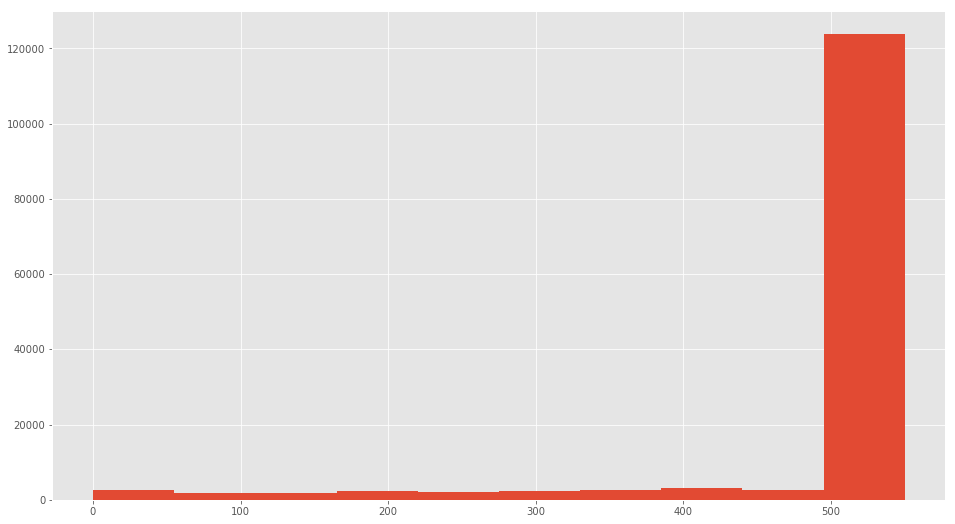

In [50]:
page_counts.data_count.hist()

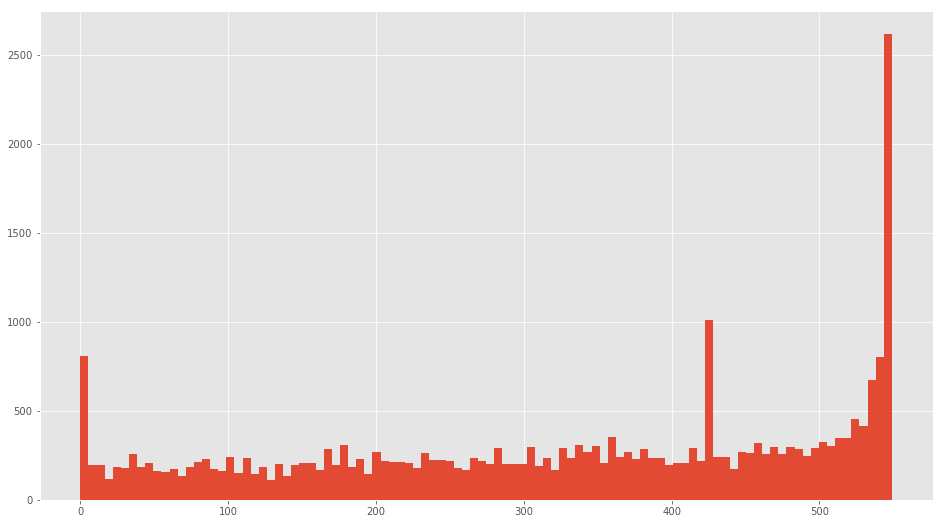

In [51]:
page_counts[page_counts.data_count < 550].data_count.hist(bins=100)

In [52]:
df = pd.read_feather(PROPHET_PATH+RESULTS_PATH+VERSION[:-1]+'df.f')
page_index = pd.read_feather(PROPHET_PATH+'page_index.f')

In [53]:
page_index.head()

,page_index,Page
0,0,2NE1_zh.wikipedia.org_all-access_spider
1,1,2PM_zh.wikipedia.org_all-access_spider
2,2,3C_zh.wikipedia.org_all-access_spider
3,3,4minute_zh.wikipedia.org_all-access_spider
4,4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...


In [54]:
df.head()

,page_index,v2.6_full,v2.6_val
0,61780,27.773549,21.464761
1,88262,39.201190,100.961816
2,38562,21.890778,33.040040
3,139999,52.019643,64.424648
4,60766,81.080621,60.384127


In [55]:
df.count()

page_index    145063
v2.6_full     144411
v2.6_val      143868
dtype: int64

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 3 columns):
page_index    145063 non-null object
v2.6_full     144411 non-null float64
v2.6_val      143868 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.3+ MB


In [74]:
fin_df = mediandf.merge(page_index, on='Page')
fin_df['page_index'] = fin_df['page_index'].astype(str)

In [75]:
len(fin_df)

145063

In [76]:
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145063 entries, 0 to 145062
Data columns (total 7 columns):
Unnamed: 0             145063 non-null int64
Page                   145063 non-null object
median_pred            145063 non-null float64
median_pred_nonzero    145063 non-null float64
nans                   145063 non-null int64
median_smape           143868 non-null float64
page_index             145063 non-null object
dtypes: float64(3), int64(2), object(2)
memory usage: 8.9+ MB


In [77]:
page_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Data columns (total 2 columns):
page_index    145063 non-null object
data_count    145063 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.2+ MB


In [79]:
fin_df = fin_df.merge(page_counts, on='page_index')

In [80]:
len(fin_df)

145063

In [81]:
(fin_df['Unnamed: 0'] == fin_df['page_index']).sum()

0

In [82]:
fin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145063 entries, 0 to 145062
Data columns (total 8 columns):
Unnamed: 0             145063 non-null int64
Page                   145063 non-null object
median_pred            145063 non-null float64
median_pred_nonzero    145063 non-null float64
nans                   145063 non-null int64
median_smape           143868 non-null float64
page_index             145063 non-null object
data_count             145063 non-null int64
dtypes: float64(3), int64(3), object(2)
memory usage: 10.0+ MB


In [83]:
fin_df['page_index'] = fin_df['page_index'].astype(str)

In [84]:
fin_df = fin_df.merge(df, on='page_index')

In [85]:
fin_df.columns

Index(['Unnamed: 0', 'Page', 'median_pred', 'median_pred_nonzero', 'nans',
       'median_smape', 'page_index', 'data_count', 'v2.6_full', 'v2.6_val'],
      dtype='object')

In [86]:
fin_df['proph_better_than_median'] = fin_df['median_smape'] - fin_df[VERSION[:-1]+'_val']

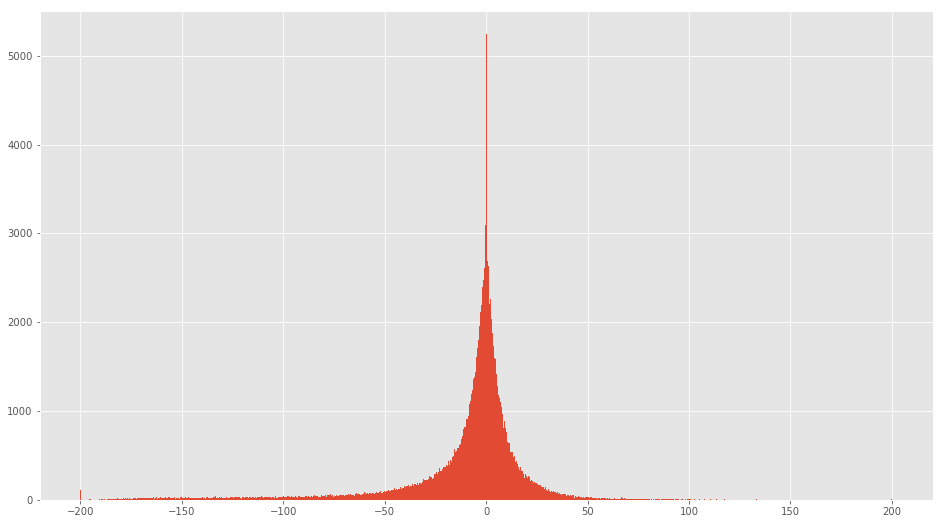

In [87]:
fin_df['proph_better_than_median'].hist(bins=1000)

In [88]:
len(fin_df[fin_df['proph_better_than_median'] > 10])

20129

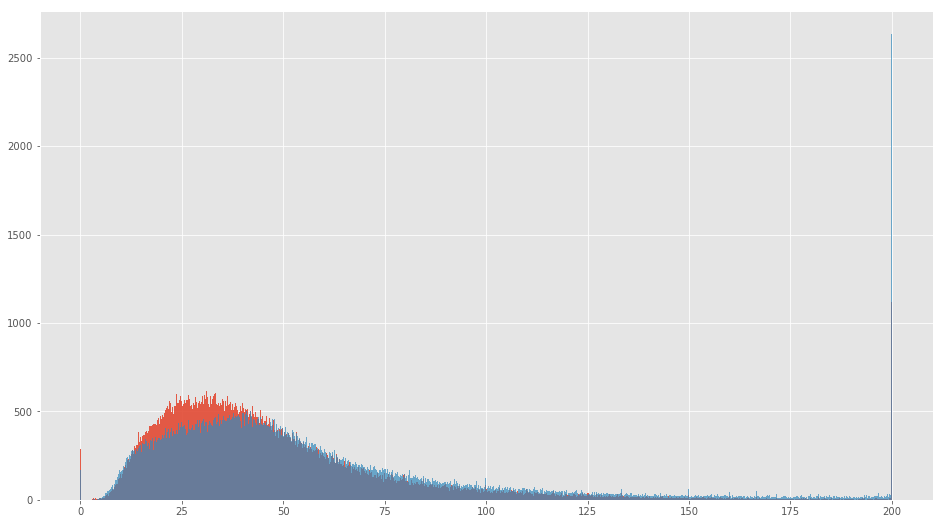

In [89]:
fin_df['median_smape'].hist(bins=1000, alpha=0.9)
fin_df[VERSION[:-1]+'_val'].hist(bins=1000, alpha=0.7)

In [90]:
fin_df.columns

Index(['Unnamed: 0', 'Page', 'median_pred', 'median_pred_nonzero', 'nans',
       'median_smape', 'page_index', 'data_count', 'v2.6_full', 'v2.6_val',
       'proph_better_than_median'],
      dtype='object')

page_index 69431 69431
Page Schießerei_in_München_am_22._Juli_2016_de.wikipedia.org_desktop_all-agents
median_pred 1.0
median_smape 200.0
v2.5_val 97.43589743589743
v2.5_better_than_median 200.0


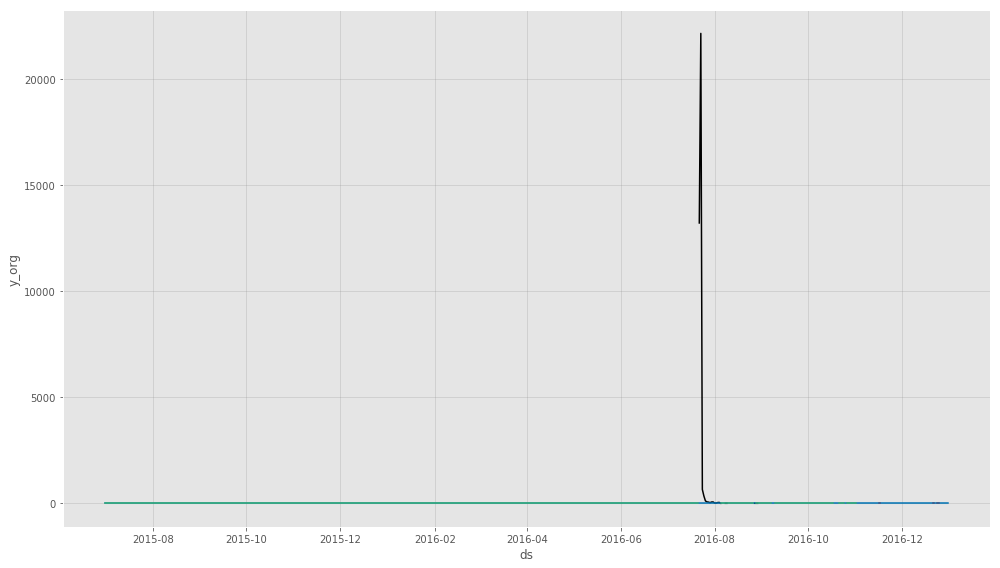

In [91]:
for row in fin_df.sort_values(by='proph_better_than_median',ascending=False).iloc[:1].iterrows():
    print('page_index', row[1][0], row[1][6])
    print('Page', row[1][1])
    print('median_pred', row[1][2])
    print('median_smape', row[1][5])
    print('v2.5_val', row[1][8])
    print('v2.5_better_than_median', row[1][-1])
    load_plot(row[1][6])

In [92]:
len(fin_df[fin_df['proph_better_than_median'] > 0])

59913

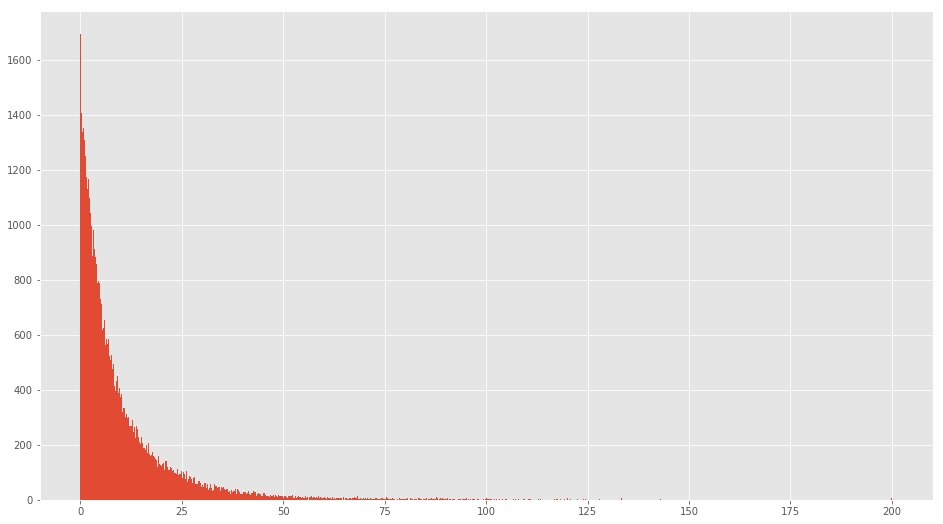

In [93]:
fin_df[fin_df['proph_better_than_median'] > 0]['proph_better_than_median'].hist(bins=1000)

page_index 105735 105735
Page 戴立忍_zh.wikipedia.org_mobile-web_all-agents
median_pred 106.0
median_smape 36.82001581470799
v2.5_val 32.964582407106185
v2.5_better_than_median 0.10049304671424863


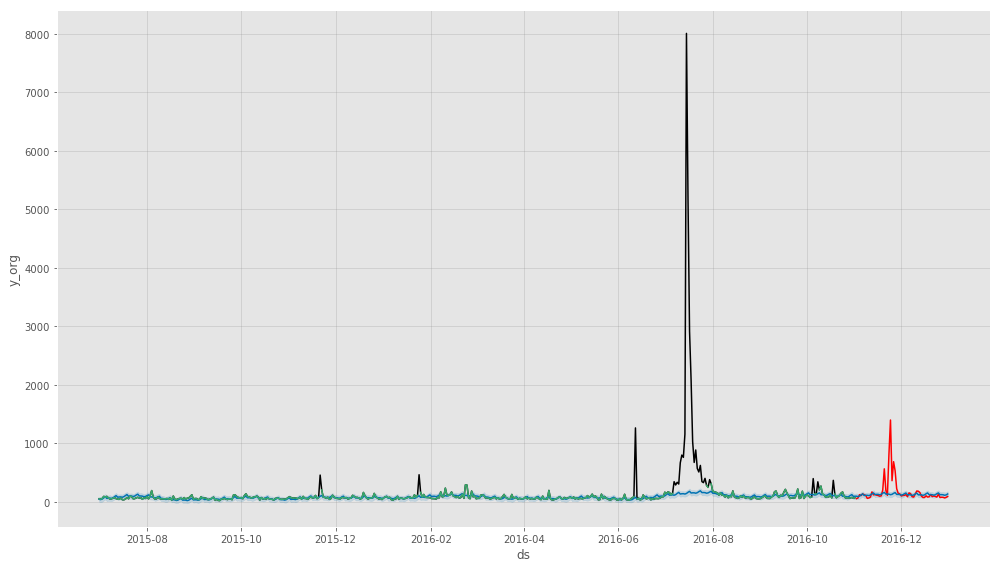

In [94]:
for row in fin_df[fin_df['proph_better_than_median'] > 0.1].sort_values(
    by='proph_better_than_median',ascending=True).iloc[:1].iterrows():
    print('page_index', row[1][0], row[1][6])
    print('Page', row[1][1])
    print('median_pred', row[1][2])
    print('median_smape', row[1][5])
    print('v2.5_val', row[1][8])
    print('v2.5_better_than_median', row[1][-1])
    load_plot(row[1][6])

page_index 82266 82266
Page File:Sun_Club_Hot_Oil_Wresting_2012-02.jpg_commons.wikimedia.org_desktop_all-agents
median_pred 9.0
median_smape 38.43170688698717
v2.5_val 53.98507820970443
v2.5_better_than_median 0.500016330243632


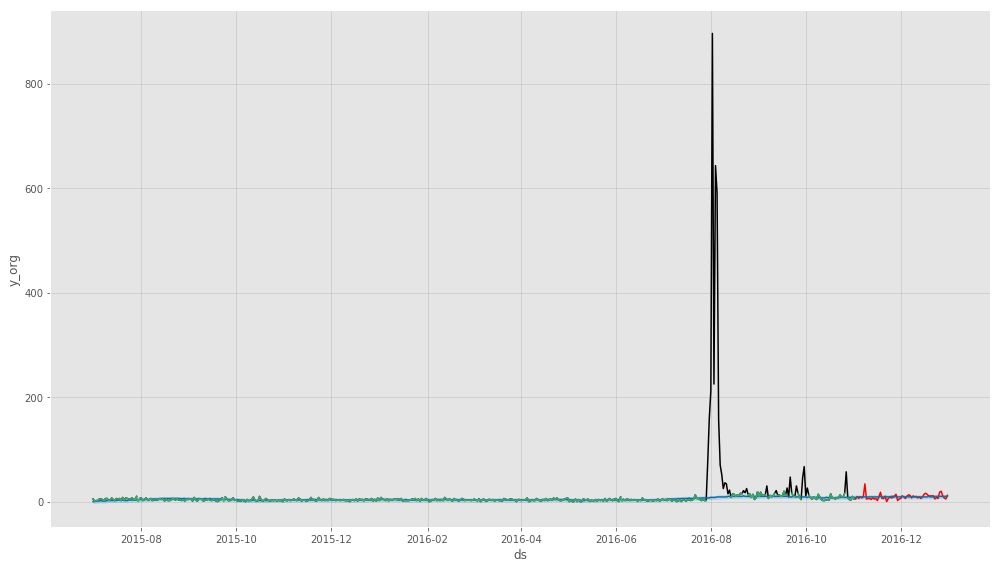

In [95]:
for row in fin_df[fin_df['proph_better_than_median'] > 0.5].sort_values(
    by='proph_better_than_median',ascending=True).iloc[:1].iterrows():
    print('page_index', row[1][0], row[1][6])
    print('Page', row[1][1])
    print('median_pred', row[1][2])
    print('median_smape', row[1][5])
    print('v2.5_val', row[1][8])
    print('v2.5_better_than_median', row[1][-1])
    load_plot(row[1][6])

page_index 13406 13406
Page Category:Canidae_vulva_commons.wikimedia.org_all-access_spider
median_pred 1.0
median_smape 115.7777777777778
v2.5_val 103.85194805194806
v2.5_better_than_median 1.0000000000000142


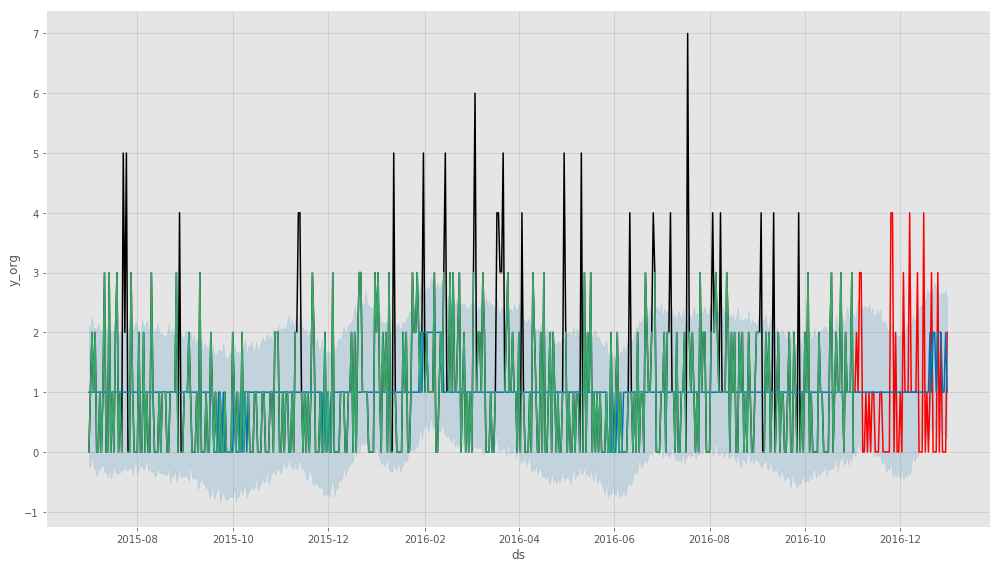

In [96]:
for row in fin_df[fin_df['proph_better_than_median'] > 1].sort_values(
    by='proph_better_than_median',ascending=True).iloc[:1].iterrows():
    print('page_index', row[1][0], row[1][6])
    print('Page', row[1][1])
    print('median_pred', row[1][2])
    print('median_smape', row[1][5])
    print('v2.5_val', row[1][8])
    print('v2.5_better_than_median', row[1][-1])
    load_plot(row[1][6])

page_index 58048 58048
Page 緒方孝市_ja.wikipedia.org_mobile-web_all-agents
median_pred 1260.0
median_smape 104.7959710771854
v2.5_val 39.717271697369775
v2.5_better_than_median 50.00924193205356


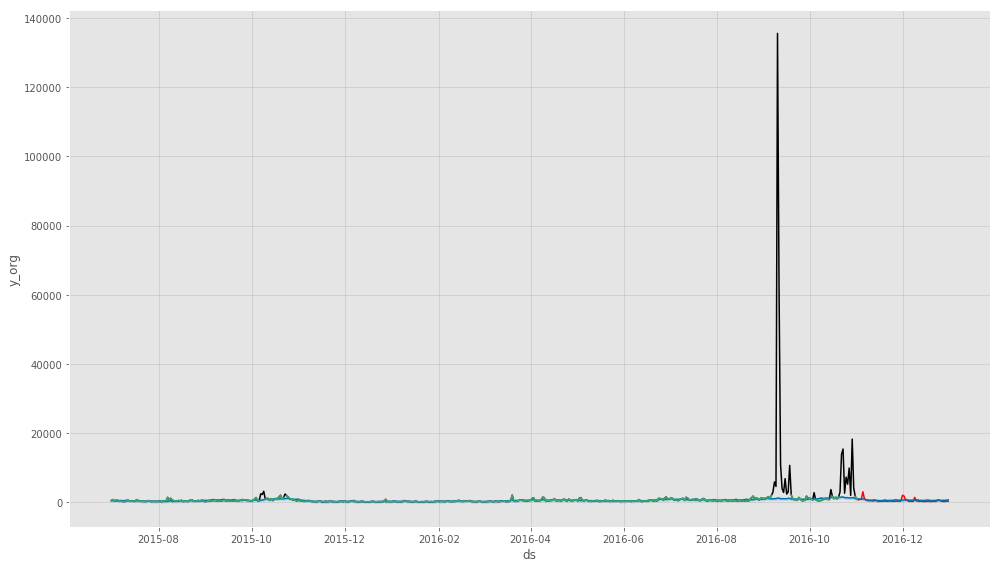

In [97]:
for row in fin_df[fin_df['proph_better_than_median'] > 50].sort_values(
    by='proph_better_than_median',ascending=True).iloc[:1].iterrows():
    print('page_index', row[1][0], row[1][6])
    print('Page', row[1][1])
    print('median_pred', row[1][2])
    print('median_smape', row[1][5])
    print('v2.5_val', row[1][8])
    print('v2.5_better_than_median', row[1][-1])
    load_plot(row[1][6])

page_index 143769 143769
Page Ingeniería_en_sistemas_computacionales_es.wikipedia.org_all-access_spider
median_pred 1.0
median_smape 116.66666666666669
v2.5_val 51.44322048500434
v2.5_better_than_median 100.00000000000001


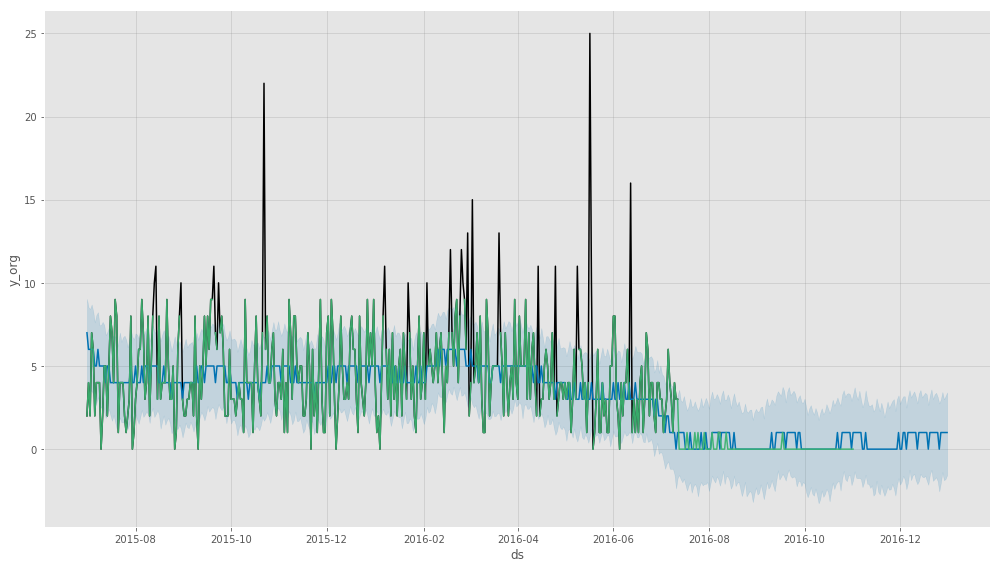

In [98]:
for row in fin_df[fin_df['proph_better_than_median'] > 100].sort_values(
    by='proph_better_than_median',ascending=True).iloc[:1].iterrows():
    print('page_index', row[1][0], row[1][6])
    print('Page', row[1][1])
    print('median_pred', row[1][2])
    print('median_smape', row[1][5])
    print('v2.5_val', row[1][8])
    print('v2.5_better_than_median', row[1][-1])
    load_plot(row[1][6])

In [99]:
(fin_df[fin_df['proph_better_than_median'] >0][VERSION[:-1]+'_val'].mean()
 + fin_df[fin_df['proph_better_than_median'] <=0]['median_smape'].mean())/2

42.822030604050823

# Produce lists for median and for prophet

In [129]:
fin_df[fin_df['proph_better_than_median'] >0].reset_index()[['Page','page_index']].to_feather(
    PROPHET_PATH+BLENDS_PATH+VERSION[:-1]+'-pages-of-'+VERSION[:-1]+'-and-'+'median'+'.f')

In [130]:
fin_df[fin_df['proph_better_than_median'] <=0].reset_index()[['Page','page_index']].to_feather(
    PROPHET_PATH+BLENDS_PATH+'median'+'-pages-of-'+VERSION[:-1]+'-and-'+'median'+'.f')

In [131]:
fin_df[fin_df['proph_better_than_median'] >0].reset_index()[['Page','page_index']].head()

,Page,page_index
0,2PM_zh.wikipedia.org_all-access_spider,1
1,4minute_zh.wikipedia.org_all-access_spider,3
2,5566_zh.wikipedia.org_all-access_spider,5
3,91Days_zh.wikipedia.org_all-access_spider,6
4,ASTRO_zh.wikipedia.org_all-access_spider,10


In [132]:
test = pd.read_feather(PROPHET_PATH+BLENDS_PATH+VERSION[:-1]+'-pages-of-'+VERSION[:-1]+'-and-'+'median'+'.f')

# Relation between Val and data_count

In [100]:
fin_df.loc[:,[VERSION[:-1]+'_val','median_smape','data_count']].corr()

,v2.6_val,median_smape,data_count
v2.6_val,1.000000,0.602433,-0.406061
median_smape,0.602433,1.000000,-0.386520
data_count,-0.406061,-0.386520,1.000000


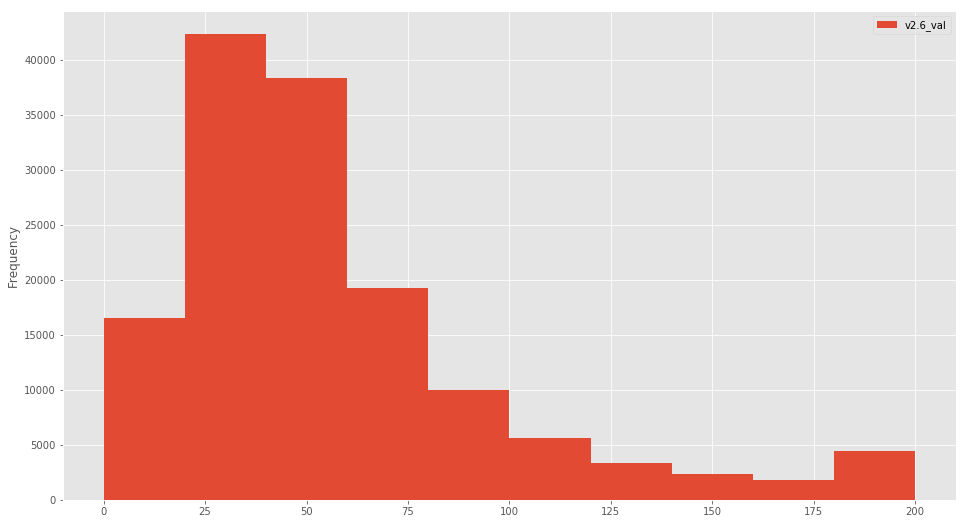

In [101]:
fin_df.sort_values(by='data_count').plot(x='data_count', y=VERSION[:-1]+'_val', kind='hist')

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.expanding_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).mean()
  """Entry point for launching an IPython kernel.


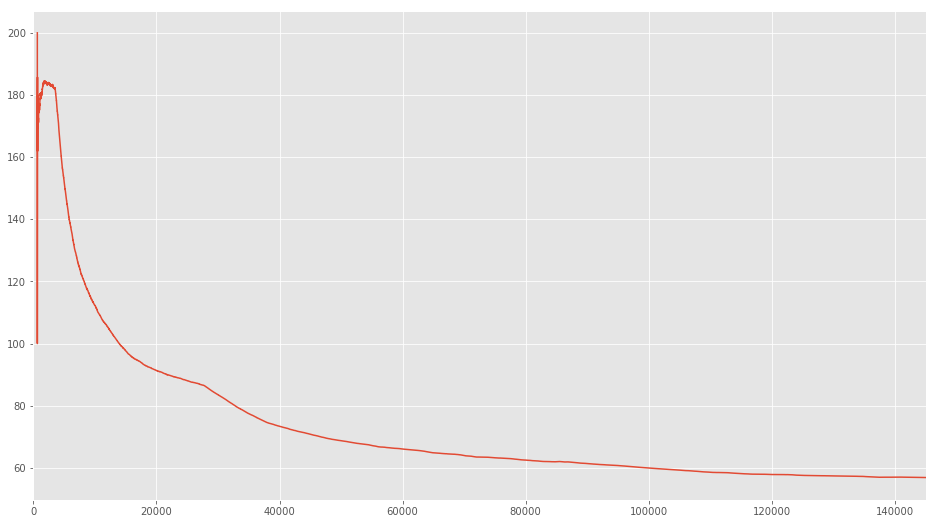

In [109]:
pd.expanding_mean(fin_df.sort_values(by='data_count')[VERSION[:-1]+'_val']).reset_index()[VERSION[:-1]+'_val'].plot()

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.expanding_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).mean()
  """Entry point for launching an IPython kernel.


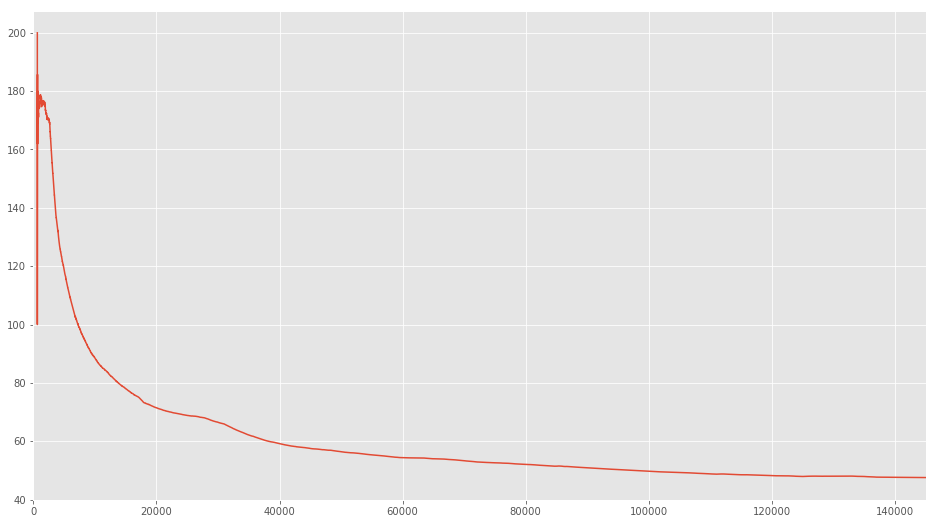

In [120]:
pd.expanding_mean(fin_df.sort_values(by='data_count')['median_smape']).reset_index()['median_smape'].plot()

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  """Entry point for launching an IPython kernel.


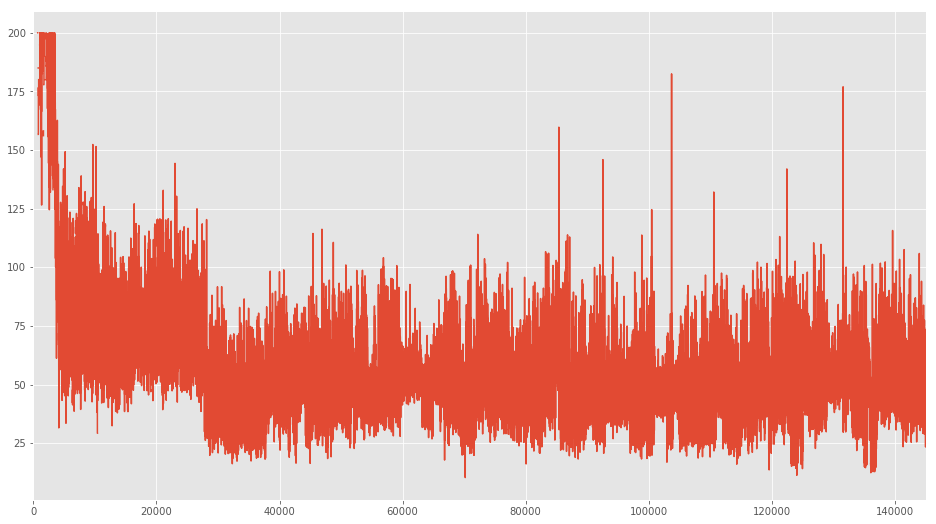

In [112]:
pd.rolling_mean(fin_df.sort_values(by='data_count')[VERSION[:-1]+'_val'],
                window=10).reset_index()[VERSION[:-1]+'_val'].plot()

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1000,center=False).mean()
  


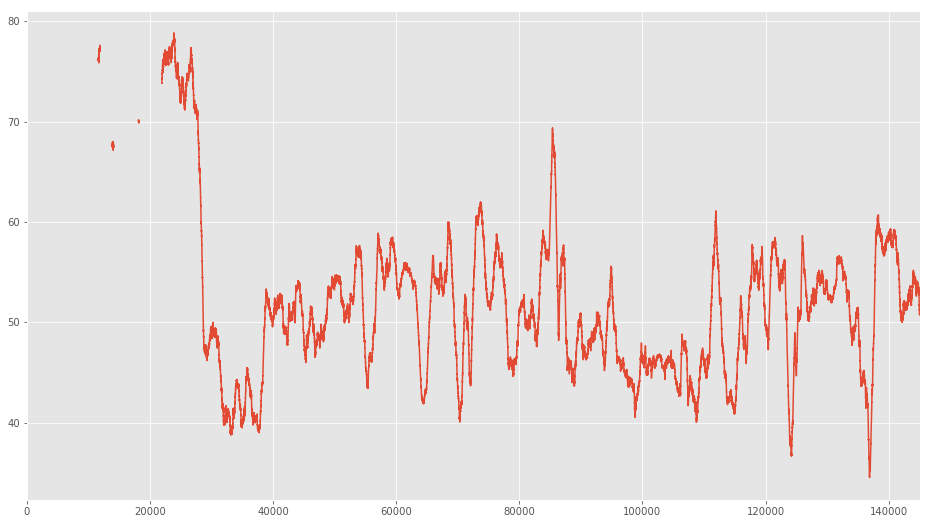

In [115]:
pd.rolling_mean(fin_df.sort_values(by='data_count')[VERSION[:-1]+'_val'],
                window=1000).reset_index()[VERSION[:-1]+'_val'].plot()

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1000,center=False).std()
  


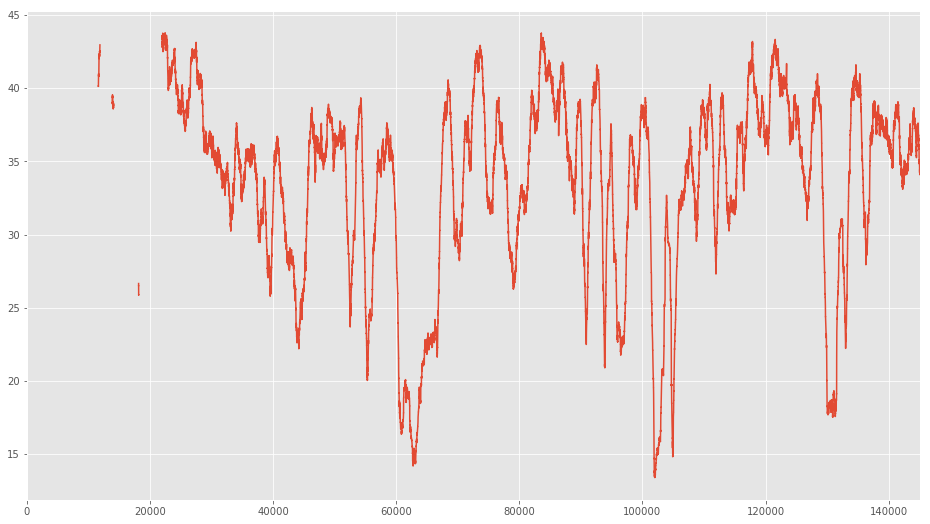

In [119]:
pd.rolling_std(fin_df.sort_values(by='data_count')[VERSION[:-1]+'_val'],
                window=1000).reset_index()[VERSION[:-1]+'_val'].plot()

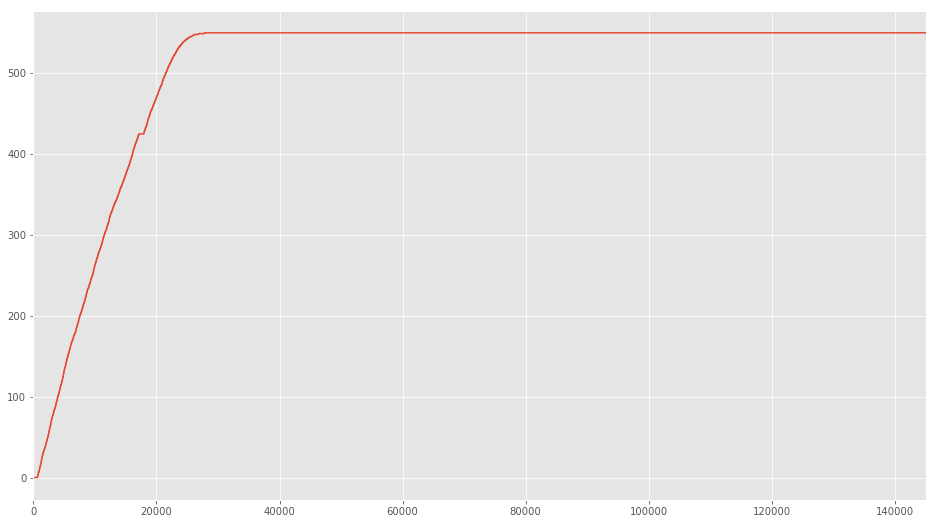

In [118]:
fin_df.sort_values(by='data_count').reset_index()['data_count'].plot()

In [116]:
fin_df.sort_values(by='data_count').iloc[30000]

Unnamed: 0                                                             139777
Page                        Landtagswahl_in_Sachsen-Anhalt_2016_de.wikiped...
median_pred                                                               180
median_pred_nonzero                                                       180
nans                                                                        0
median_smape                                                          28.3584
page_index                                                             139777
data_count                                                                550
v2.6_full                                                             42.0879
v2.6_val                                                               76.978
proph_better_than_median                                             -48.6196
Name: 139777, dtype: object

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()
  


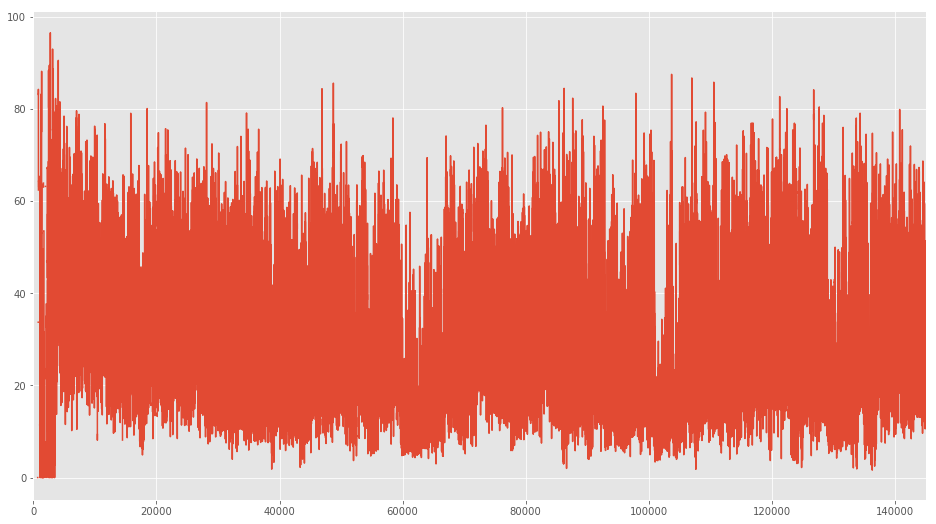

In [114]:
pd.rolling_std(fin_df.sort_values(by='data_count')[VERSION[:-1]+'_val'],
                window=10).reset_index()[VERSION[:-1]+'_val'].plot()